# This notebook demonstrates self-distillation of a Denoising Diffusion transformer model

# Imports

In [2]:
# !pip install diffusers timm --upgrade
# !pip install filelock

['cin_original', 'DSDGEXP', 'DSDGL', 'DSDI', 'DSDN', 'FID', 'TSD']
c:\Diffusion_Thesis\cin_256/NPZ/cin_cin_original


Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to C:\Users\Damion/.cache\torch\hub\checkpoints\pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:02<00:00, 34.9MB/s]


Saving statistics for c:\Diffusion_Thesis\cin_256/saved_images/cin/cin_original/16/


  0%|          | 0/469 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [23]:
basic_path_target

'c:\\Diffusion_Thesis\\cin_256/NPZ/celeb'

In [8]:
from pytorch_fid import fid_score
fid_score.save_fid_stats()

TypeError: save_fid_stats() missing 4 required positional arguments: 'paths', 'batch_size', 'device', and 'dims'

In [1]:
from util_DiT import *
import os
%reload_ext autoreload
%autoreload 2
import torch
from torchvision.utils import save_image
from diffusion import create_diffusion
from diffusers.models import AutoencoderKL
from download import find_model
from models import DiT_XL_2
from PIL import Image
from IPython.display import display
# torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("GPU not found. Using CPU instead.")

cwd = os.getcwd()

c:\Users\Administrator\anaconda3\envs\DSD\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Creating Model

In [2]:
# Setting up image sizes
image_size = 256 #@param [256, 512]
vae_model = "stabilityai/sd-vae-ft-ema" #@param ["stabilityai/sd-vae-ft-mse", "stabilityai/sd-vae-ft-ema"]
latent_size = int(image_size) // 8

# Load model:
model = DiT_XL_2(input_size=latent_size).to(device)
state_dict = find_model(f"DiT-XL-2-{image_size}x{image_size}.pt")
model.load_state_dict(state_dict)
model.eval() # important!
vae = AutoencoderKL.from_pretrained(vae_model).to(device)

# Doing a single denoising step

In [4]:
n = 1
num_sampling_steps = 4 #@param {type:"slider", min:0, max:1000, step:1}
cfg_scale = 4 #@param {type:"slider", min:1, max:10, step:0.1}
class_labels = [207]
samples_per_row = 4 #@param {type:"number"}

# Create diffusion object:
diffusion = create_diffusion(str(num_sampling_steps))
# Sample inputs:
z = torch.randn(1, model.in_channels, latent_size, latent_size, device=device)
y = torch.randint(0, 1, (n,), device=device)

# Setup classifier-free guidance:

z = torch.cat([z, z], 0)
y_null = torch.tensor([1000] * n, device=device)
y = torch.cat([y, y_null], 0)
model_kwargs = dict(y=y, cfg_scale=4)
sample_fn = model.forward_with_cfg


# Sample images:
samples = diffusion.ddim_sample_loop_progressive(
    sample_fn, z.shape, z, clip_denoised=False, model_kwargs=model_kwargs, progress=False, device=device
)

samples, _ = samples.chunk(2, dim=0)  # Remove null class samples

samples = vae.decode(samples / 0.18215).sample
save_image(samples, "sample.png", nrow=int(samples_per_row), 
           normalize=True, value_range=(-1, 1))
samples = Image.open("sample.png")
display(samples)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:27                                                                                   │
│                                                                                                  │
│   24 │   sample_fn, z.shape, z, clip_denoised=False, model_kwargs=model_kwargs, progress=Fals    │
│   25 )                                                                                           │
│   26                                                                                             │
│ ❱ 27 samples, _ = samples.chunk(2, dim=0)  # Remove null class samples                           │
│   28                                                                                             │
│   29 samples = vae.decode(samples / 0.18215).sample                                              │
│   30 save_image(samples, "sample.png", nrow=int(samples_per_row),                                │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'generator' object has no attribute 'chunk'

In [5]:
samples, pred_xstart = sample_step_grad(model.forward_with_cfg_grad, diffusion, 4, model_kwargs, timesteps, samples)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 samples, pred_xstart = sample_step_grad(model.forward_with_cfg_grad, diffusion, step, mo     │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'sample_step_grad' is not defined

# Distillation Loop

In [3]:
import util_DiT
import os
%reload_ext autoreload
%autoreload 2
import torch
from torchvision.utils import save_image
from diffusion import create_diffusion
from diffusers.models import AutoencoderKL
from download import find_model
from models import DiT_XL_2
from PIL import Image
from IPython.display import display
torch.set_grad_enabled(True)
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cuda"
if device == "cpu":
    print("GPU not found. Using CPU instead.")

cwd = os.getcwd()
# Setting up image sizes
image_size = 256 #@param [256, 512]
vae_model = "stabilityai/sd-vae-ft-ema" #@param ["stabilityai/sd-vae-ft-mse", "stabilityai/sd-vae-ft-ema"]
latent_size = int(image_size) // 8

# Load model:
model = DiT_XL_2(input_size=latent_size).to(device)
state_dict = find_model(f"DiT-XL-2-{image_size}x{image_size}.pt")
model.load_state_dict(state_dict)
model.eval() # important!
vae = AutoencoderKL.from_pretrained(vae_model).to("cuda")
del state_dict, vae_model
torch.cuda.empty_cache()
steps = 20
generations = 10
decrease_steps = False

# !set 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:128'

[3, 2, 1, 0]


100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


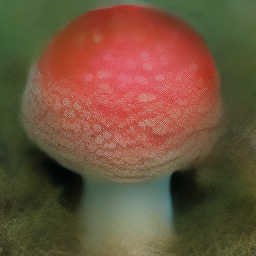

In [4]:
# # Set user inputs:
# seed = 0 #@param {type:"number"}
# torch.manual_seed(seed)
num_sampling_steps = 4 #@param {type:"slider", min:0, max:1000, step:1}
cfg_scale = 4 #@param {type:"slider", min:1, max:10, step:0.1}
class_labels = [992] #@param {type:"raw"}
samples_per_row = 1 #@param {type:"number"}

# Create diffusion object:
diffusion = create_diffusion(str(num_sampling_steps))

# Create sampling noise:
n = 1
z = torch.randn(n, 4, latent_size, latent_size, device=device)
y = torch.tensor(class_labels, device=device)

# Setup classifier-free guidance:
z = torch.cat([z, z], 0)
y_null = torch.tensor([1000] * n, device=device)
y = torch.cat([y, y_null], 0)
model_kwargs = dict(y=y, cfg_scale=cfg_scale)

# Sample images:
samples = diffusion.ddim_sample_loop_progressive(
    model.forward_with_cfg, z.shape, z, clip_denoised=False, 
    model_kwargs=model_kwargs, progress=True, device=device
)
samples, _ = samples.chunk(2, dim=0)  # Remove null class samples
samples = vae.decode(samples / 0.18215).sample

# Save and display images:
save_image(samples, "sample.png", nrow=int(samples_per_row), 
           normalize=True, value_range=(-1, 1))
samples = Image.open("sample.png")
display(samples)

# With intermediate steps!

In [6]:
# # Set user inputs:
# seed = 0 #@param {type:"number"}
# torch.manual_seed(seed)
import tqdm
num_sampling_steps =4 #@param {type:"slider", min:0, max:1000, step:1}
cfg_scale = 4 #@param {type:"slider", min:1, max:10, step:0.1}
class_labels = [992] #@param {type:"raw"}
samples_per_row = 1 #@param {type:"number"}

# Create diffusion object:
diffusion = create_diffusion(str(num_sampling_steps))
diffusion_original = create_diffusion(str(num_sampling_steps))

# Create sampling noise:
n = 1
z = torch.randn(n, 4, latent_size, latent_size, device=device)
y = torch.tensor(class_labels, device=device)

# Setup classifier-free guidance:
z = torch.cat([z, z], 0)
y_null = torch.tensor([1000] * n, device=device)
y = torch.cat([y, y_null], 0)
model_kwargs = dict(y=y, cfg_scale=cfg_scale)


samples = torch.randn(z.shape, device=device)
indices = list(range(diffusion.num_timesteps))[::-1]
for i in tqdm.tqdm(indices):
    print(i)
    samples = diffusion.ddim_sample_loop_progressive_intermediate(
            model.forward_with_cfg, z.shape, noise=samples, clip_denoised=False, 
            model_kwargs=model_kwargs, progress=False, device=device, step=i)
    img, _ = samples.chunk(2, dim=0)  # Remove null class samples
    img = vae.decode(img / 0.18215).sample
    if i == 1:
        last = img
    else:
        final = img
    # Save and display images:
    save_image(img, "sample.png", nrow=int(samples_per_row), 
            normalize=True, value_range=(-1, 1))
    img = Image.open("sample.png")
    display(img)



In [ ]:
from torch.cuda.amp import GradScaler, autocast

scaler = GradScaler()


def self_distillation_dit(diffusion, original_diffusion, optimizer, scheduler,
            session=None, steps=20, generations=200, early_stop=True, run_name="test", decrease_steps=False,
            step_scheduler="deterministic", type="snellius"):
    """
    Distill a model into itself. This is done by having a (teacher) model distill knowledge into itself. Copies of the original model and sampler 
    are passed in to compare the original untrained version with the distilled model at scheduled intervals.
    """
    NUM_CLASSES = 1000
    gradient_updates = generations
    ddim_steps_student = steps
    TEACHER_STEPS = 2
    ddim_eta = 0.0
    scale = 3.0
    optimizer=optimizer
    averaged_losses = []
    criterion = nn.MSELoss()
    instance = 0
    generation = 0
    all_losses = []

    if step_scheduler == "iterative":
        halvings = math.floor(math.log(64)/math.log(2))
        updates_per_halving = int(gradient_updates / halvings)
        step_sizes = []
        for i in range(halvings):
            step_sizes.append(int((steps) / (2**i)))
        update_list = []
        for i in step_sizes:
            update_list.append(int(updates_per_halving / int(i/ 2)))
    elif step_scheduler == "naive":
        step_sizes=[ddim_steps_student]
        update_list=[gradient_updates // int(ddim_steps_student / 2)]
    elif step_scheduler == "gradual_linear":
        step_sizes = np.arange(steps, 0, -2)
        update_list = (1/len(np.append(step_sizes[1:], 1)) * gradient_updates / np.append(step_sizes[1:], 1)).astype(int)
    elif step_scheduler == "gradual_exp":
        step_sizes = np.arange(64, 0, -2)
        update_list = np.exp(1 / np.append(step_sizes[1:],1)) / np.sum(np.exp(1 / np.append(step_sizes[1:],1)))
        update_list = (update_list * gradient_updates /  np.append(step_sizes[1:],1)).astype(int)

    n = 1
    num_sampling_steps =4 #@param {type:"slider", min:0, max:1000, step:1}
    cfg_scale = 4 #@param {type:"slider", min:1, max:10, step:0.1}
    samples_per_row = 1 #@param {type:"number"}
    indices = list(range(diffusion.num_timesteps))[::-1]
    with torch.no_grad():
        # with student.ema_scope():              
              

                for i, step in enumerate(step_sizes):
                    # if instance != 0 and "gradual" not in step_scheduler:
                    #     util.save_model(sampler_student, optimizer, scheduler, name=step_scheduler, steps=updates, run_name=run_name)
                    updates = int(step / 2)
                    generations = update_list[i]
                    print("Distilling to:", updates)
                    
                    # sc = student.get_learned_conditioning({student.cond_stage_key: torch.tensor(1*[1000]).to(student.device)})
                    
                    
                    with tqdm.tqdm(torch.randint(0, NUM_CLASSES, (generations,))) as tepoch:

                        for i, class_prompt in enumerate(tepoch):
                            generation += 1
                            losses = []        
                            class_labels = torch.tensor([class_prompt])
                            z = torch.randn(n, 4, latent_size, latent_size, device=device)
                            y = torch.tensor(class_labels, device=device)
                            z = torch.cat([z, z], 0)
                            y_null = torch.tensor([1000] * n, device=device)
                            y = torch.cat([y, y_null], 0)
                            model_kwargs = dict(y=y, cfg_scale=cfg_scale)
                            samples_ddim= None
                            predictions_temp = []
                            samples = torch.randn(z.shape, device=device)
                            for steps in range(updates):  

                                    with autocast():

                                        with torch.enable_grad():
                                            
                                            instance += 1
                                        
                                            
                                            
                                            optimizer.zero_grad()
                                            
                                            
                                            samples_ddim, pred_x0_student, _, at= sampler_student.sample_student(S=1,
                                                                                conditioning=c_student,
                                                                                batch_size=1,
                                                                                shape=[3, 64, 64],
                                                                                verbose=False,
                                                                                x_T=samples_ddim,
                                                                        
                                                                                unconditional_guidance_scale=scale,
                                                                                unconditional_conditioning=sc, 
                                                                                eta=ddim_eta,
                                                                                keep_intermediates=False,
                                                                                intermediate_step = steps*2,
                                                                                steps_per_sampling = 1,
                                                                                total_steps = step)
                                        

                                        with torch.no_grad():
                                            
                                            samples_ddim, _, _, pred_x0_teacher, _ = sampler_student.sample(S=1,
                                                                            conditioning=c_student,
                                                                            batch_size=1,
                                                                            shape=[3, 64, 64],
                                                                            verbose=False,
                                                                            x_T=samples_ddim,
                                                                            unconditional_guidance_scale=scale,
                                                                            unconditional_conditioning=sc, 
                                                                            eta=ddim_eta,
                                                                            keep_intermediates=False,
                                                                            intermediate_step = steps*2+1,
                                                                            steps_per_sampling = 1,
                                                                            total_steps = step)     
                                        
                                        
                                    
                                        with torch.enable_grad():    
                                            
                                            # # AUTOCAST:
                                            # signal = at
                                            # noise = 1 - at
                                            # log_snr = torch.log(signal / noise)
                                            # weight = max(log_snr, 1)
                                            # loss = weight * criterion(pred_x0_student, pred_x0_teacher.detach())
                                            # scaler.scale(loss).backward()
                                            # scaler.step(optimizer)
                                            # scaler.update()
                                            # # torch.nn.utils.clip_grad_norm_(sampler_student.model.parameters(), 1)
                                            
                                            # scheduler.step()
                                            # losses.append(loss.item())

                                            
                                            # NO AUTOCAST:
                                            signal = at
                                            noise = 1 - at
                                            log_snr = torch.log(signal / noise)
                                            weight = max(log_snr, 1)
                                            loss = weight * criterion(pred_x0_student, pred_x0_teacher.detach())
                                            # loss = criterion(pred_x0_student, pred_x0_teacher.detach())
                                            loss.backward()
                                            optimizer.step()
                                            scheduler.step()
                                            torch.nn.utils.clip_grad_norm_(sampler_student.model.parameters(), 1)
                                            
                                            losses.append(loss.item())
                                            
                                        if session != None and generation % 200 == 0 and generation > 0:
                                                
                                            x_T_teacher_decode = sampler_student.model.decode_first_stage(pred_x0_teacher)
                                            teacher_target = torch.clamp((x_T_teacher_decode+1.0)/2.0, min=0.0, max=1.0)
                                            x_T_student_decode = sampler_student.model.decode_first_stage(pred_x0_student.detach())
                                            student_target  = torch.clamp((x_T_student_decode +1.0)/2.0, min=0.0, max=1.0)
                                            predictions_temp.append(teacher_target)
                                            predictions_temp.append(student_target)
                                            
                                        
                                    

                                        # if session != None and instance % 10000 == 0 and generation > 0:
                                        #     fids = util.get_fid(student, sampler_student, num_imgs=100, name=run_name, instance = instance+1, steps=[64, 32, 16, 8, 4, 2, 1])
                                        #     session.log({"fid_64":fids[0]})
                                        #     session.log({"fid_32":fids[1]})
                                        #     session.log({"fid_16":fids[2]})
                                        #     session.log({"fid_8":fids[3]})
                                        #     session.log({"fid_4":fids[4]})
                                        #     session.log({"fid_2":fids[5]})
                                        #     session.log({"fid_1":fids[6]})
                                        
                                        if session != None and instance % 2000 == 0:
                                            
                                            with torch.no_grad():
                                                images, _ = util.compare_teacher_student(original, sampler_original, student, sampler_student, steps=[64, 32, 16, 8,  4, 2, 1], prompt=992)
                                                images = wandb.Image(_, caption="left: Teacher, right: Student")
                                                wandb.log({"pred_x0": images})
                                                # images, _ = util.compare_teacher_student_with_schedule(original, sampler_original, student, sampler_student, steps=[64, 32, 16, 8,  4, 2, 1], prompt=992)
                                                # images = wandb.Image(_, caption="left: Teacher, right: Student")
                                                # wandb.log({"schedule": images})
                                                sampler_student.make_schedule(ddim_num_steps=ddim_steps_student, ddim_eta=ddim_eta, verbose=False)
                                                sampler_original.make_schedule(ddim_num_steps=ddim_steps_student, ddim_eta=ddim_eta, verbose=False)

                            if generation > 0 and generation % 20 == 0 and ddim_steps_student != 1 and step_scheduler=="FID":
                                fid = util.get_fid(student, sampler_student, num_imgs=100, name=run_name, 
                                            instance = instance, steps=[ddim_steps_student])
                                if fid[0] <= current_fid[0] * 0.9 and decrease_steps==True:
                                    print(fid[0], current_fid[0])
                                    if ddim_steps_student in [16, 8, 4, 2, 1]:
                                        name = "intermediate"
                                        saving_loading.save_model(sampler_student, optimizer, scheduler, name, steps * 2, run_name)
                                    if ddim_steps_student != 2:
                                        ddim_steps_student -= 2
                                        updates -= 1
                                    else:
                                        ddim_steps_student = 1
                                        updates = 1    
                                    current_fid = fid
                                    print("steps decreased:", ddim_steps_student)    

                            if session != None:
                                with torch.no_grad():
                                    if session != None and generation % 200 == 0 and generation > 0:
                                        img, grid = util.compare_latents(predictions_temp)
                                        images = wandb.Image(grid, caption="left: Teacher, right: Student")
                                        wandb.log({"Inter_Comp": images})
                                        del img, grid, predictions_temp, x_T_student_decode, x_T_teacher_decode, student_target, teacher_target
                                        torch.cuda.empty_cache()
                            
                            all_losses.extend(losses)
                            averaged_losses.append(sum(losses) / len(losses))
                            if session != None:
                                session.log({"generation_loss":averaged_losses[-1]})
                            tepoch.set_postfix(epoch_loss=averaged_losses[-1])

                if step_scheduler == "naive" or "gradual" in step_scheduler:
                    util.save_model(sampler_student, optimizer, scheduler, name=step_scheduler, steps=updates, run_name=run_name)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 diffusion.model.ema_scope()                                                                  │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'SpacedDiffusion' object has no attribute 'model'